In [1]:
# Imports 
import matplotlib.pyplot as plt
import xarray as xr
import datetime as dt

from eodag import EODataAccessGateway
from eodag import setup_logging

from rasterio.crs import CRS
from rioxarray.merge import merge_arrays

import eotools.shortcut as eoshort
import eotools.loading as eoload
import eotools.contrast as eocontrast

# Setup Verbose Values:
# 0: no logging and no progress bar
# 1: no logging but progress bars displayed
# 2: log at the INFO level
# 3: log at the DEBUG level (even more information)

setup_logging(verbose=1)

# Image Processing
This Notebook intends to show some examples of image processing.

## Data Retrieval/Acquisition
The first Lines of Code, which essentialy load the data are not explained, since the Notebooks 01 and 02 do that.

In [2]:
# Get Credentials from .env file and make dirs from paths.yml
# These functions are just shortcuts from a python script and just help to keep the notebooks short and simple
workspace = eoshort.read_paths(filepath='paths.yml')
dag = EODataAccessGateway()
dag.set_preferred_provider("cop_dataspace")

deserialized_search_results = eoshort.deserialize(filename="search_results.geojson", workspace=workspace, dag=dag, log=True)

# Download multiple Products
products = deserialized_search_results
paths = dag.download_all(products)

Got 4 deserialized products.


Downloaded products:   0%|          | 0/4 [00:00<?, ?product/s]

0.00B [00:00, ?B/s]

0.00B [00:00, ?B/s]

0.00B [00:00, ?B/s]

0.00B [00:00, ?B/s]

In [3]:
# Set Boundingbox for Area inside the Tile.
latmin, latmax = 48.1, 48.35
lonmin, lonmax = 16.1, 16.6
extent = {'lonmin': lonmin, 'latmin': latmin, 'lonmax': lonmax, 'latmax': latmax}

# Setting common Parameters for all further image processing
common_params = dict(
    crs=CRS.from_epsg(4326),               # the downloaded images are in 4326, don't reproject them
    resolution=0.0006,                     # but lower their resolution (0.0006 should be 60m in 100km)
    extent=(lonmin,latmin,lonmax,latmax)   # and zoom over/crop the area of interest
)

# Define basic Functions for future operations
def normalized_difference(a, b):
    return (a - b*1.)/(a + b)

def normalize(a):
    return (a - a.min())/(a.max() - a.min())    

In [4]:
# Get all Bands from products
assets = eoload.load_assets(paths[0], res=10, only_spectral=True, include_tci=False)
assets

['B02', 'B03', 'B04', 'B08']

In [5]:
# Get Products from same Tile
tile_ds = sorted([p for p in products if 'T33UWP' == p.properties['title'].split('_')[5]], key=lambda p: p.properties["title"].split("_")[2])

# Loading multiple Bands into a dataset with multiple Timestamps
ds = eoload.load_multiple_timestamps_regex(products=tile_ds, bands=assets, **common_params)
ds

<xarray.Dataset> Size: 11MB
Dimensions:      (time: 2, x: 833, y: 416)
Coordinates:
  * time         (time) object 16B 2024-05-04 2024-05-06
  * x            (x) float64 7kB 16.1 16.1 16.1 16.1 ... 16.49 16.49 16.49 16.49
  * y            (y) float64 3kB 48.35 48.35 48.35 48.35 ... 48.1 48.1 48.1 48.1
    band         int32 4B 1
    spatial_ref  int32 4B 0
Data variables:
    B02          (time, y, x) float32 3MB 2.928e+03 2.85e+03 ... 0.0 0.0
    B03          (time, y, x) float32 3MB 2.992e+03 2.952e+03 ... 0.0 0.0
    B04          (time, y, x) float32 3MB 2.706e+03 2.662e+03 ... 0.0 0.0
    B08          (time, y, x) float32 3MB 5.209e+03 5.465e+03 ... 0.0 0.0

## Image Processing

### Stacking

In order to display an array, the array needs to have either one or three channels. If there is one color channel the image or array will be displayed as a *black and white* (greyscale) image, but any colormap can be chosen. If the array has three colors each "layer" will be interpreted as one of the RGB colors.

In this example a single image from the dataset is chosen.

In [6]:
# Select a single Timestamp from the Dataset (both of the following methods work)
single_img = ds.sel(time=dt.datetime(2024, 5, 1), method='nearest')

Then the individual bands are extracted from the dataarray and stacked to create an dataarray with 3 color dimensions. Additionally the image is normalized, so that the image is not just nonsense. If you are curiose try to plot the image without the normalize function.

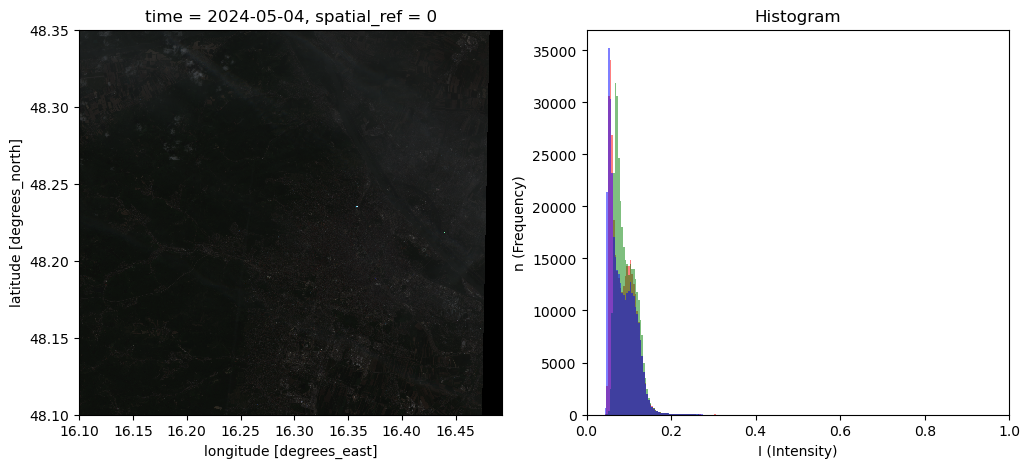

In [7]:
# Stack each Band into a single RGB Image
rgb = xr.concat([single_img['B04'], single_img['B03'], single_img['B02']], dim='band')
single_img['rgb'] = normalize(rgb)

# Plot the RGB image and its histogram
fig, axs = plt.subplots(1,2, figsize=(12,5))
single_img['rgb'].plot.imshow(ax=axs[0])
eocontrast.histogram(single_img['rgb'], xlim=(0,1), ax=axs[1])
plt.show()

### Contrast

The Image still has very bad contrast and does not resemble an RGB Image.
To fix this problem we can increase the contrast of the image. To do this we implement the functions which are stored in `eotools.contrast`. For more details on how these functions work and why we need them to increase contrast and correctly encode the data, take a look at https://www.cg.tuwien.ac.at/courses/EinfVisComp/Skriptum/SS13/EVC-11%20Point%20Operations.pdf for a great overview. In your own Code it might be helpful, if you put those functions in a Python script and import the script into your code. First we can use the `auto_clip()` or `clip()` function to set values of intensity which are outside of a boundary to the boundary border: 

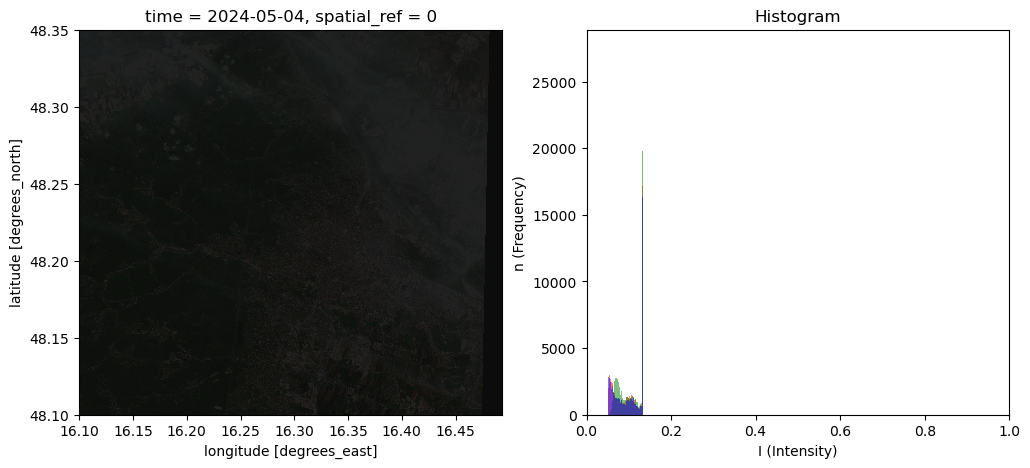

In [8]:
# Clip the RGB Image
clipped = eocontrast.auto_clip_dataarray(single_img['rgb'], percentile=0.05, pooled = True)
single_img['clipped'] = clipped

# Plot the RGB image and its histogram
fig, axs = plt.subplots(1,2, figsize=(12,5))
single_img['clipped'].plot.imshow(ax=axs[0])
eocontrast.histogram(single_img['clipped'], xlim=(0,1), ax=axs[1])
plt.show()

You can see that the histogram now has clear borders, and all the values below/above these borders have been set to the border values. You can play around clipping fewer/more values by setting the percentile value in the `auto_clip()` function. The `pooled` parameter sets if the bands get clipped individually (`=FALSE`) or as a group (`=TRUE`).

As the intensity of the values is still too low after clipping we have to stretch the values to spread between 0 and 1. We can do this by using the `stretch()` function. If you have a look at the histogram you can see, that the RGB values are evenly spaced from 0 to 1.

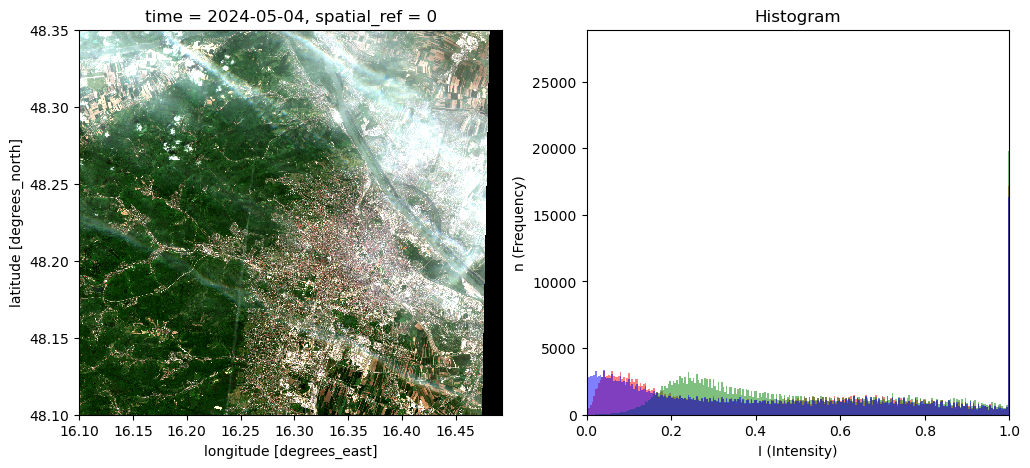

In [9]:
# Strech the clipped RGB Image
stretched = eocontrast.stretch_dataarray(single_img['clipped'], 0, 1, pooled = True)
single_img['stretch'] = stretched

# Plot the RGB image and its histogram
fig, axs = plt.subplots(1,2, figsize=(12,5))
single_img['stretch'].plot.imshow(ax=axs[0])
eocontrast.histogram(single_img['stretch'], xlim=(0,1), ax=axs[1])
plt.show()

If the final image doesnt look natural or still seems too dark try playing around with the percentile value or set the intensity value manually with the `clip()` function instead of `auto_clip()`. If an individual band has a higher intensity compared to the others try setting `pooled` to `=FALSE` when clipping and stretching. 

### False Color Image

As we want to analyze our picture regarding forested areas, we can make this easier using a false color image. Vegetetation reflects light in much higher intensities in the near infrared side of the spectrum. To visualize this we can replace the red band in the rgb image with the NIR band (=band 8) 

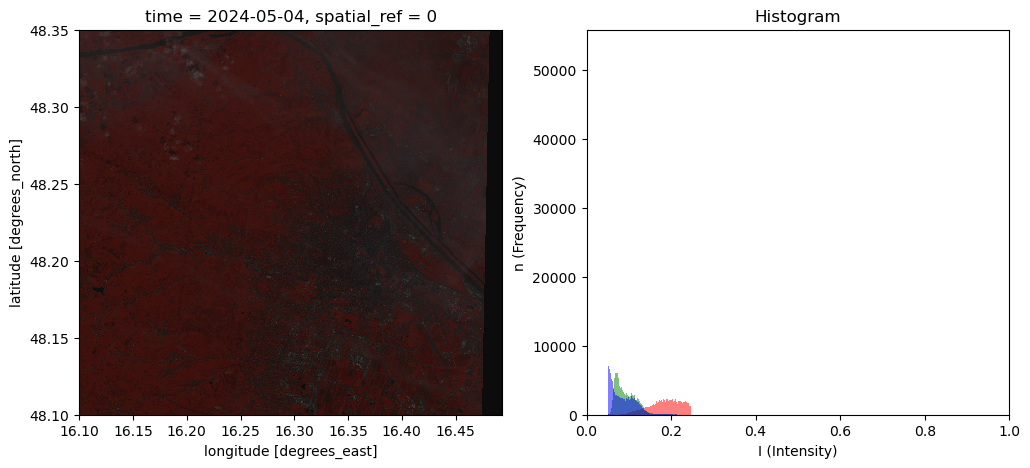

In [19]:
fc = xr.concat([single_img['B08'], single_img['B03'], single_img['B02']], dim='band')
single_img['fc'] = eocontrast.auto_clip_dataarray(eocontrast.stretch_dataarray(fc, p_min=0, p_max=1, pooled=True),percentile=0.05, pooled=True)

fig, axs = plt.subplots(1,2, figsize=(12,5))
single_img['fc'].plot.imshow(ax=axs[0])
eocontrast.histogram(single_img['fc'], ax=axs[1], xlim=(0,1))
plt.show()

We can see that the NIR values are slightly higher than the ones of the green and blue band. So this time we will change the `pooled` parameter to `False` when incresing the contrast. You can also see the difference when the `pooled` parameter is set to `True`.

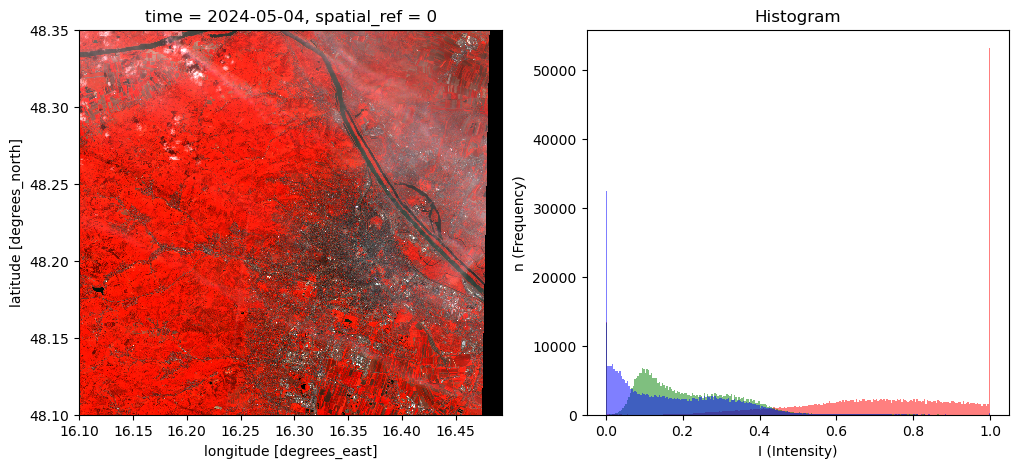

In [18]:
fc_stretched_false = eocontrast.stretch_dataarray(single_img['fc'], 0, 1, pooled=True)
single_img['fc-streched'] = fc_stretched_false

fig, axs = plt.subplots(1,2, figsize=(12,5))
single_img['fc-streched'].plot.imshow(ax=axs[0])
eocontrast.histogram(single_img['fc-streched'], ax=axs[1])
plt.show()


## Cloud Filtering

Now we want to generate an Image which has no clud coverage. To do this we need a few different images from different times. We will then get the median values from each pixel. With this method the Clouds should gone. There might be errors if the selected images all have a very high cloud coverage.

In [23]:
# Creat a Cloudfree Image from the median of all Timestamps
cloudfree_img = ds.median(dim="time")

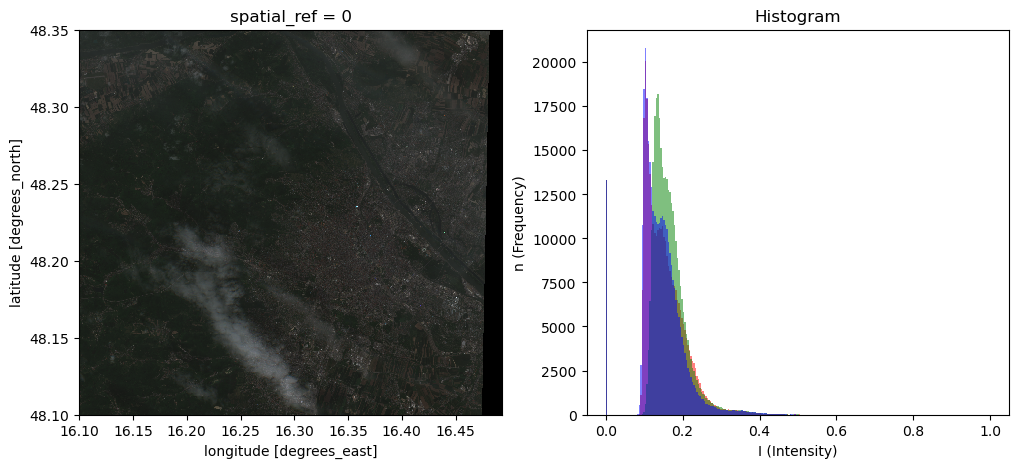

In [24]:
# Plot the RGB image and its histogram of the cloudfree image
cf_rgb = xr.concat([cloudfree_img['B04'], cloudfree_img['B03'], cloudfree_img['B02']], dim='band')
cloudfree_img['rgb'] = normalize(cf_rgb)

fig, axs = plt.subplots(1,2, figsize=(12,5))
cloudfree_img['rgb'].plot.imshow(ax=axs[0])
eocontrast.histogram(cloudfree_img['rgb'], ax=axs[1])
plt.show()

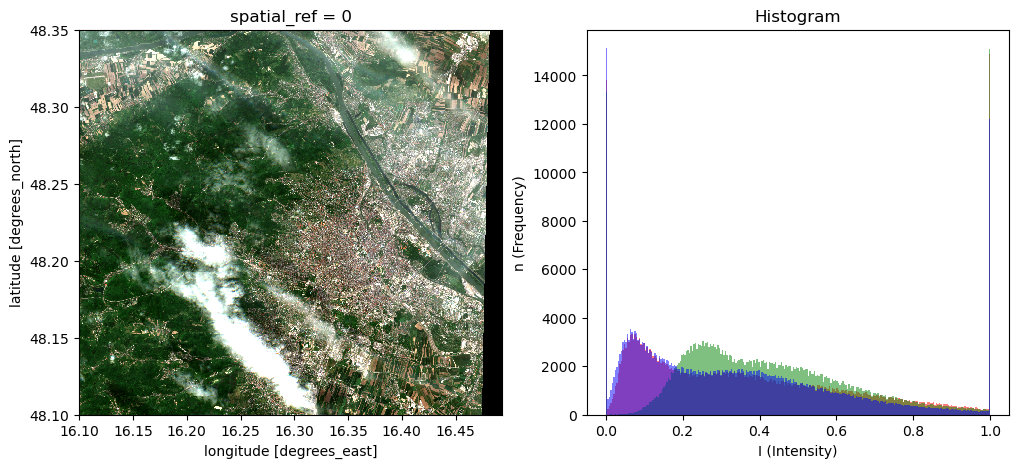

In [25]:
cf_clipped = eocontrast.auto_clip_dataarray(cloudfree_img['rgb'], percentile=0.04, pooled=True)
cf_stretched = eocontrast.stretch_dataarray(cf_clipped, 0, 1, pooled=True)
cloudfree_img['stretched'] = cf_stretched

fig, axs = plt.subplots(1,2, figsize=(12,5))
cloudfree_img['stretched'].plot.imshow(ax=axs[0])
eocontrast.histogram(cloudfree_img['stretched'], ax=axs[1])
plt.show()

Since this example has only two timestamps, the median image will not be very cloudfree.